Credit card fraud is an importnat issue for majority of businesses,This notebook will focus on two techniques for detecting fradulent transactions,machine learning and autoencoders, our problem is in that the majority of transactions are not fraud (legitimate) so we have an imbalanced dataset.

Let's import the required libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.metrics import f1_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler



# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings("ignore")

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

/kaggle/input/creditcardfraud/creditcard.csv


Reading in data

In [2]:
data = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Exploring in data 

In [3]:
data.shape

(284807, 31)

In [4]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [5]:
data.dtypes.value_counts()

float64    30
int64       1
dtype: int64

In [6]:
data.isnull().sum().any()

False

In [7]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [8]:
data.Class.value_counts().rename(index = {0:'Not Fraud', 1:'Fraud'})

Not Fraud    284315
Fraud           492
Name: Class, dtype: int64

Out of 285k transactions just 492 were labelled as fraudulent, it is a small percentage but may represent billions of dollars of lost revenue each year.

In [9]:
data['Time'] = StandardScaler().fit_transform(data['Time'].values.reshape(-1, 1))
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [10]:
y = data.Class
X = data.drop('Class',axis=1)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)

In [12]:
lr_rs = LogisticRegression(C=1)
lr_rs.fit(X_train,y_train)
pred = lr_rs.predict(X_test)

In [13]:
matrix = confusion_matrix(y_test, pred)
matrix

array([[85286,    10],
       [   63,    84]])

In [14]:
tpos = matrix[0][0]
fneg = matrix[1][1]
fpos = matrix[0][1]
tneg = matrix[1][0]

In [15]:
print( 'Accuracy: '+ str(np.round(100*float(tpos+fneg)/float(tpos+fneg + fpos + tneg),2))+'%')
print( 'Cohen Kappa: '+ str(np.round(cohen_kappa_score(y_test, pred),3)))
print("Sensitivity/Recall for Model : {}".format(round(recall_score(y_test, pred), 2)))
print("F1 Score for Model : {}".format(round(f1_score(y_test, pred), 2)))

Accuracy: 99.91%
Cohen Kappa: 0.697
Sensitivity/Recall for Model : 0.57
F1 Score for Model : 0.7


there are two options to handle imbalanced data, over-sampling the sample of fraud records or under-sampling the sample of legitime records.

we'll use under-sampling with RandomUnderSampler technique

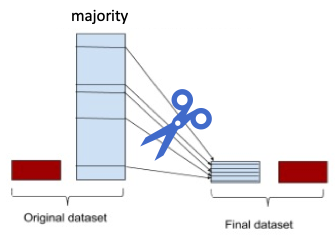

In [16]:
# RandomUnderSampler
sampler = RandomUnderSampler(ratio={1: 492, 0: 492})
X_rs, y_rs = sampler.fit_sample(X, y)

In [17]:
X_rs.shape

(984, 30)

In [18]:
X_rs_train, X_rs_test, y_rs_train, y_rs_test = train_test_split(X_rs,y_rs,test_size = 0.3)

In [19]:
lr_rs1 = LogisticRegression(C=1)
lr_rs1.fit(X_rs_train,y_rs_train)
pred1 = lr_rs1.predict(X_rs_test)

In [20]:
matrix1 = confusion_matrix(y_rs_test, pred1)
matrix1

array([[141,   6],
       [ 13, 136]])

In [21]:
tpos1 = matrix1[0][0]
fneg1 = matrix1[1][1]
fpos1 = matrix1[0][1]
tneg1 = matrix1[1][0]

In [22]:
print( 'Accuracy: '+ str(np.round(100*float(tpos1+fneg1)/float(tpos1+fneg1 + fpos1 + tneg1),2))+'%')
print( 'Cohen Kappa: '+ str(np.round(cohen_kappa_score(y_rs_test, pred1),3)))
print("Sensitivity/Recall for Model : {}".format(round(recall_score(y_rs_test, pred1), 2)))
print("F1 Score for Model : {}".format(round(f1_score(y_rs_test, pred1), 2)))

Accuracy: 93.58%
Cohen Kappa: 0.872
Sensitivity/Recall for Model : 0.91
F1 Score for Model : 0.93


In [23]:
lr_rs2 = LogisticRegression(C=1)
lr_rs2.fit(X_rs_train,y_rs_train)
pred2 = lr_rs2.predict(X_test)

In [24]:
matrix2 = confusion_matrix(y_test, pred2)
matrix2

array([[82934,  2362],
       [   12,   135]])

In [25]:
tpos2 = matrix2[0][0]
fneg2 = matrix2[1][1]
fpos2 = matrix2[0][1]
tneg2 = matrix2[1][0]

In [26]:
print( 'Accuracy: '+ str(np.round(100*float(tpos2+fneg2)/float(tpos2+fneg2 + fpos2 + tneg2),2))+'%')
print( 'Cohen Kappa: '+ str(np.round(cohen_kappa_score(y_test, pred2),3)))
print("Sensitivity/Recall for Model : {}".format(round(recall_score(y_test, pred2), 2)))
print("F1 Score for Model : {}".format(round(f1_score(y_test, pred2), 2)))

Accuracy: 97.22%
Cohen Kappa: 0.099
Sensitivity/Recall for Model : 0.92
F1 Score for Model : 0.1
